##**Model Interpretability**

##**ABSTRACT**

The dataset encapsulates a comprehensive collection of avocado sales data spanning various regions and dates. Each entry chronicles the average price of avocados and the total volume sold, alongside the detailed breakdown of sales by product categories—specifically, the PLU 4046, PLU 4225, PLU 4770 avocados, as well as small, large, and extra-large bags. The dataset further distinguishes between conventional and organic types, providing a layered perspective on consumer preferences and market dynamics.By employing machine learning techniques, including regression analysis and AutoML frameworks, we seek to understand the underlying patterns that characterize average price of avocados.Through rigorous analysis, the assignment will address the significance of relationships within the data, examine potential model assumptions and violations, and scrutinize the presence of multicollinearity. The outcome is expected to bolster strategic decision-making in agricultural production, supply chain optimization, and targeted marketing efforts.

**Objective:** To compare and contrast different methods of model interpretability by analyzing the results obtained from fitting a linear model, a tree-based model, and utilizing automated machine learning (AutoML), and subsequently applying SHAP (SHapley Additive exPlanations) analysis to each model.

In [2]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 5.7 MB/s eta 0:00:00


In [4]:
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.6/265.6 MB 4.2 MB/s eta 0:00:00


In [67]:
import pandas as pd
import shap
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(context="notebook", palette="Spectral", style = 'darkgrid' ,font_scale = 1.5, color_codes=True)
import warnings
warnings.filterwarnings('ignore')
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
from sklearn.model_selection import train_test_split as tts
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from yellowbrick.regressor import ResidualsPlot
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder

In [51]:
data = pd.read_csv('https://raw.githubusercontent.com/Jashu284/DSMT/main/avocado.csv')

In [49]:
!pip install auto-sklearn

  Using cached auto-sklearn-0.15.0.tar.gz (6.5 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached scikit-learn-0.24.2.tar.gz (7.5 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [52]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

data = data.drop(columns=['Unnamed: 0'])
# Convert 'Date' column to datetime format and extract day and month
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data['Day'] = data['Date'].dt.day
data['Month'] = data['Date'].dt.month

# Drop the original 'Date' column
data = data.drop('Date', axis=1)

# Apply one-hot encoding to 'type' and 'region' columns
encoder = OneHotEncoder()
encoded_columns = encoder.fit_transform(data[['type', 'region']]).toarray()

# Create a DataFrame with the encoded columns
# Get the feature names directly from the encoder
encoded_feature_names = encoder.get_feature_names_out()

# Now create the DataFrame with the correct column names
encoded_df = pd.DataFrame(encoded_columns, columns=encoded_feature_names)


# Concatenate the encoded columns with the original dataset
data_p = pd.concat([data, encoded_df], axis=1)

# Remove the original 'type' and 'region' columns
data_p = data_p.drop(['type', 'region'], axis=1)

# Display the first few rows of the preprocessed dataset
data_p.head()


,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year,...,region_SouthCarolina,region_SouthCentral,region_Southeast,region_Spokane,region_StLouis,region_Syracuse,region_Tampa,region_TotalUS,region_West,region_WestTexNewMexico
0,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,2015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,2015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,2015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,2015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,2015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##**LINEAR REGRESSION**

In [69]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Separate the features and the target variable
X = data_p.drop('AveragePrice', axis=1)
y = data_p['AveragePrice']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Initialize the Linear Regression model
linear_model = LinearRegression()

# Fit the model
linear_model.fit(X_train, y_train)

# Get the regression coefficients
#coefficients = pd.DataFrame(linear_model.coef_, X.columns, columns=['Coefficient'])

#coefficients.head(15)  # Display the first 10 coefficients for brevity
y_pred = linear_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

# Coefficients and intercept
coefficients = linear_model.coef_
intercept = linear_model.intercept_

print("Coefficients:", coefficients)
print("Intercept:", intercept)
print("MSE:", mse)

Coefficients: [-1.85112926e-05  1.85203345e-05  1.85007175e-05  1.85107375e-05
 -3.94543956e-02  3.94728921e-02  3.94728346e-02  3.94743244e-02
  5.13194273e-02  1.21916769e-03  2.06278915e-02 -2.45759856e-01
  2.45759762e-01  1.58612684e-01 -7.28353807e-02  1.32948106e-01
 -5.99954552e-02  1.36759594e-01  1.23973015e-01 -7.96988214e-03
  1.92074920e-01  1.44585264e-01 -2.04375781e-01 -1.61323962e-01
 -3.25967742e-01 -1.72266934e-01 -1.32999201e-01  9.53639140e-02
 -7.65298828e-02  1.10290539e-01  4.11614820e-01 -3.67661349e-01
 -8.73525649e-02  9.20769142e-02 -3.98005430e-02 -2.04554482e-01
 -1.19467130e-01  1.84389848e-02  7.49542663e-03 -1.96252908e-01
 -1.05343794e-01  3.35499537e-01  2.14015458e-01  7.22752461e-02
  9.01359984e-02  2.13654860e-01 -1.82082884e-01 -4.79855214e-02
  3.85433965e-02 -8.60216302e-02  1.50007400e-01 -1.12499920e-01
 -1.53585398e-01  1.99975014e-01 -2.34170131e-02  4.11151001e-01
  1.36839937e-02 -7.25573490e-03 -3.08247861e-01 -1.26533367e-02
  5.3473372

In [16]:
pip install --upgrade scikit-learn


In [53]:
from sklearn.inspection import PartialDependenceDisplay


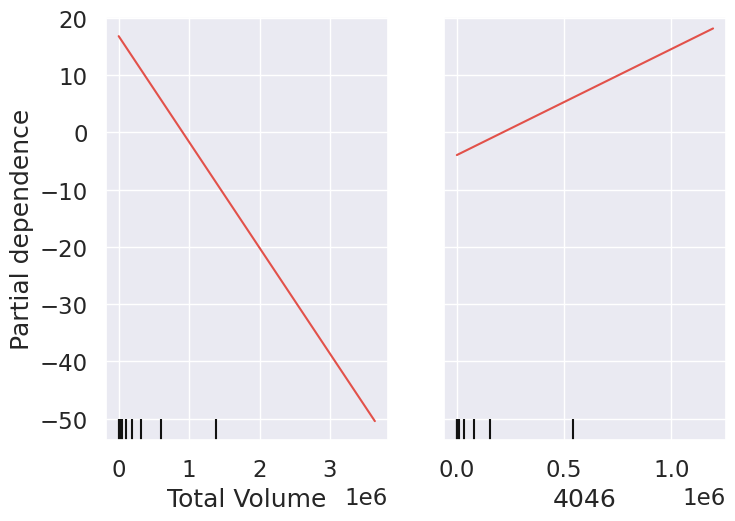

In [71]:
import matplotlib.pyplot as plt

# Assuming you want to plot partial dependence for the first two features in X_train
features = [0, 1]  # or use column names if you prefer
PartialDependenceDisplay.from_estimator(linear_model, X_train, features)
plt.show()


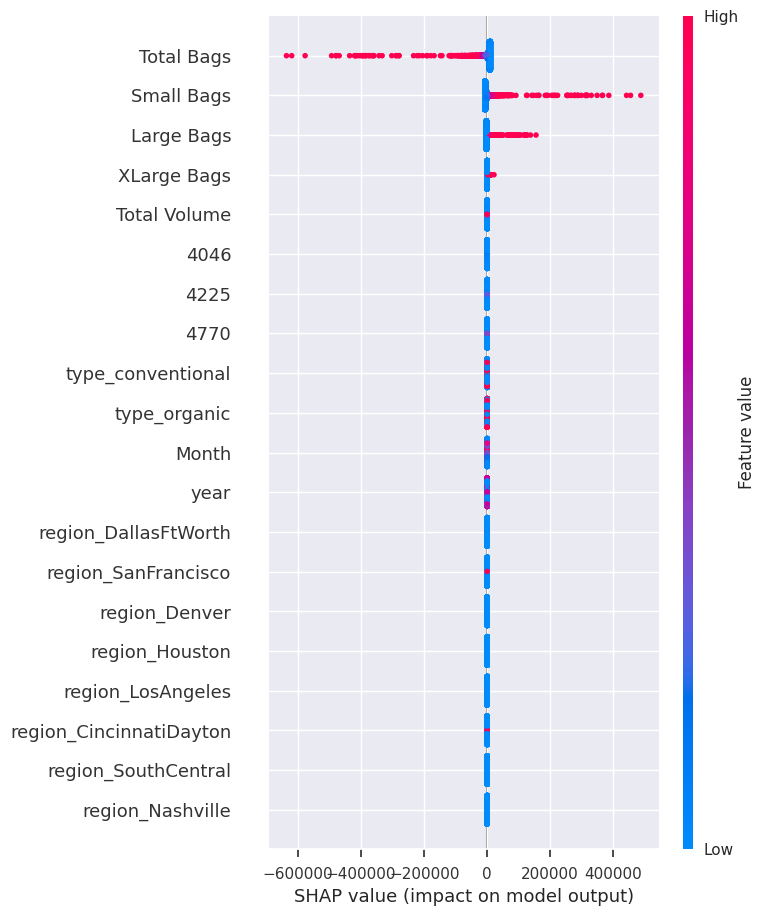

SHAP values: [ 1.47648979e+00 -7.92686628e-01 -7.31815997e-01 -1.17251628e-01
 -3.52743848e+02  3.72033537e+02 -2.35048004e+01  4.38023488e+00
 -1.55364294e-03  7.12628566e-04  1.22524024e-02  1.07393690e-02
  1.07393649e-02  2.91152051e-03 -7.08398908e-04 -3.27817249e-04
 -4.84894775e-04 -4.12152201e-04  1.93601694e-03 -9.27999975e-05
  1.71025613e-03  1.56468985e-03  4.70344262e-03 -3.00548751e-03
  4.59927087e-03  6.37151672e-03  1.76724966e-03  7.70749442e-04
  1.53059766e-03 -6.34548309e-04  6.65349982e-03  1.00729137e-03
  1.79491572e-03  5.04531037e-05 -3.98005430e-04  6.97726932e-03
  9.32825538e-04 -3.53624366e-05 -9.54896817e-05  4.14012984e-03
  2.59751820e-04  6.80190842e-03  1.14337025e-03  7.42553898e-04
 -1.60516162e-03 -2.72190438e-03 -2.79360042e-03 -9.46563710e-04
 -7.91987599e-04 -1.76756774e-03  1.08909482e-03 -9.40067821e-04
  1.36754121e-03  1.72581176e-03 -2.02092031e-04 -2.02759398e-03
  1.33090898e-04  1.39151080e-05  8.44514688e-04  1.19600031e-04
  1.01086650

In [70]:
import shap

# Ensure data is in the correct format
X_train = X_train.astype(float)
X_test = X_test.astype(float)

# Initialize the SHAP explainer with the linear model
explainer = shap.Explainer(linear_model, X_train)

# Compute SHAP values for the test set
shap_values = explainer(X_test)

# Summary plot of the SHAP values
shap.summary_plot(shap_values, X_test)

# Print the average of the SHAP values as an estimate of feature importance
print("SHAP values:", shap_values.values.mean(axis=0))


##**DECISION TREE**

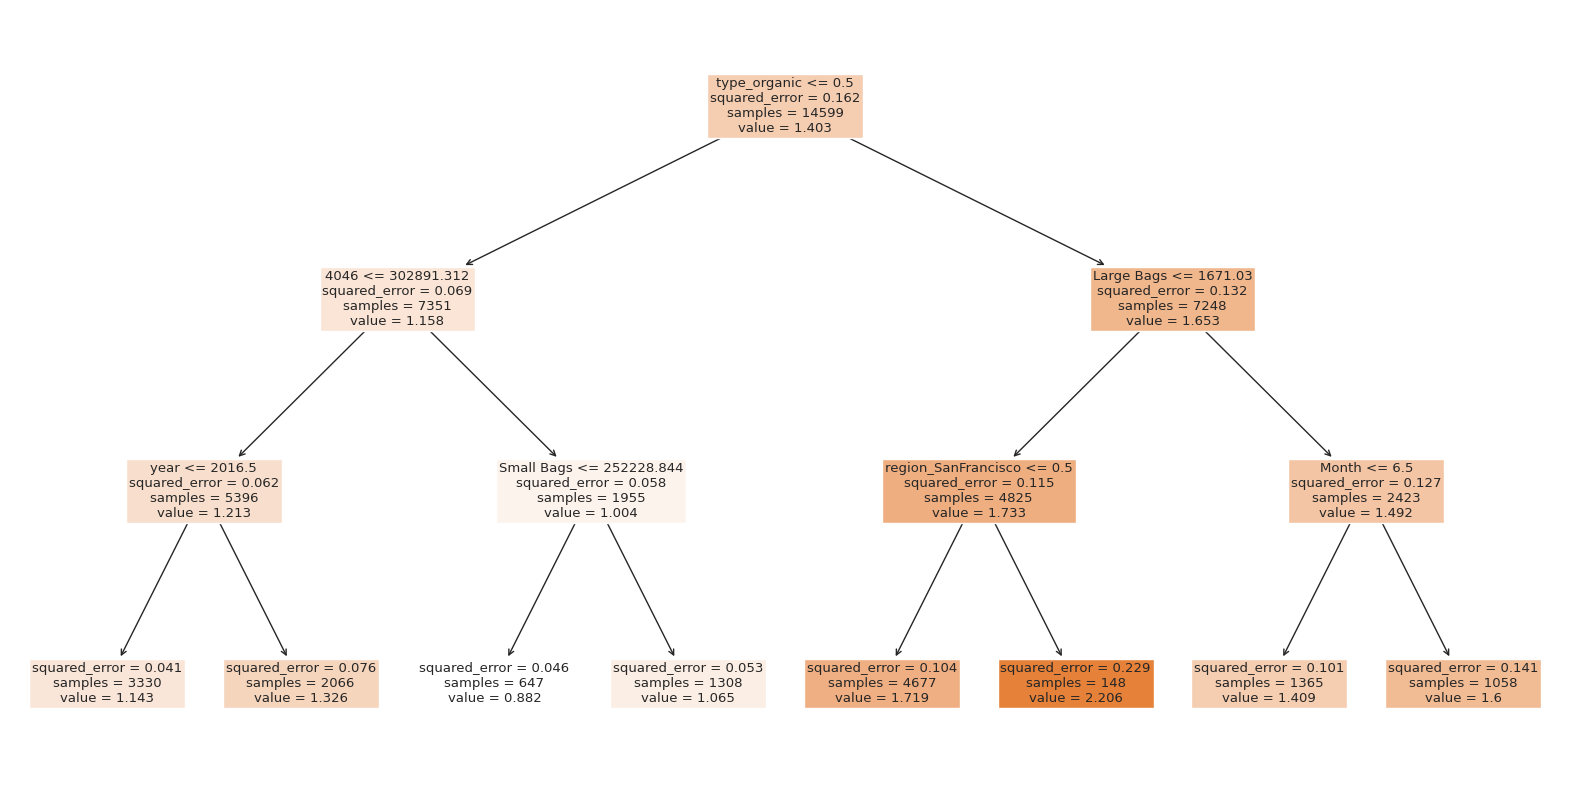

In [72]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

# Fit a decision tree regressor model
tree_model = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_model.fit(X_train, y_train)

# Plot the tree
plt.figure(figsize=(20,10))
plot_tree(tree_model, feature_names=X.columns, filled=True)
plt.show()


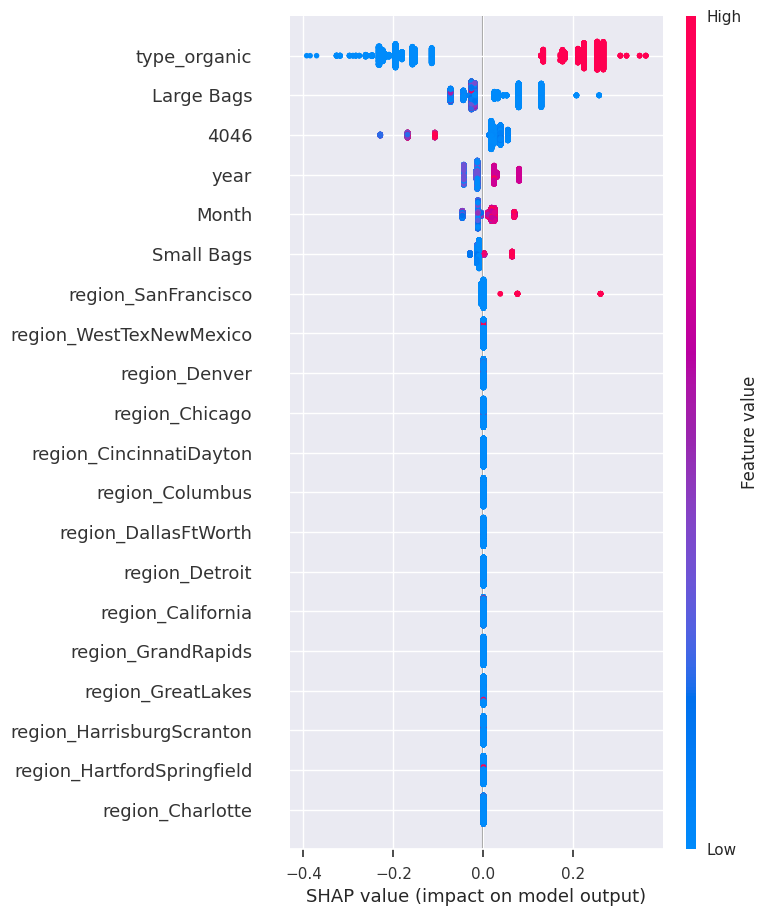

ValueError: visualize() can only display Explanation objects (or arrays of them)!

In [73]:
import shap

# Initialize the SHAP explainer with the Decision Tree model
explainer = shap.Explainer(tree_model, X_train)

# Compute SHAP values for the test set
shap_values = explainer(X_test)

# Summary plot of the SHAP values
shap.summary_plot(shap_values, X_test)

# To show the SHAP values for a single prediction, you can use force_plot
# For example, for the first instance in the test set:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])


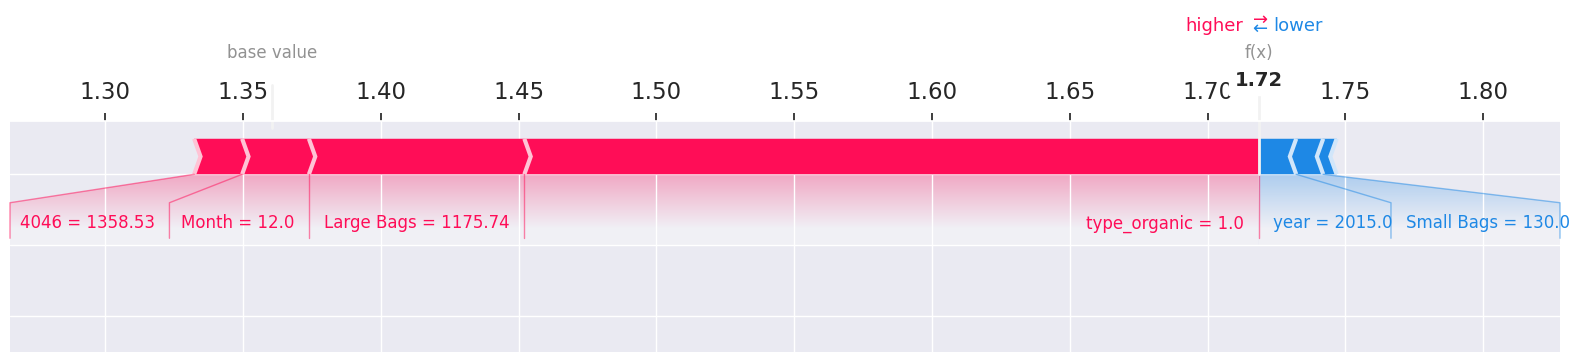

In [74]:
# Compute SHAP values for the entire test set
explainer1 = shap.Explainer(tree_model, X_train)
shap_values = explainer1(X_test)

# Generate the force plot for the first prediction in the test set
# The SHAP Explanation object can be used directly in the force_plot function
shap.force_plot(shap_values[0], matplotlib=True)


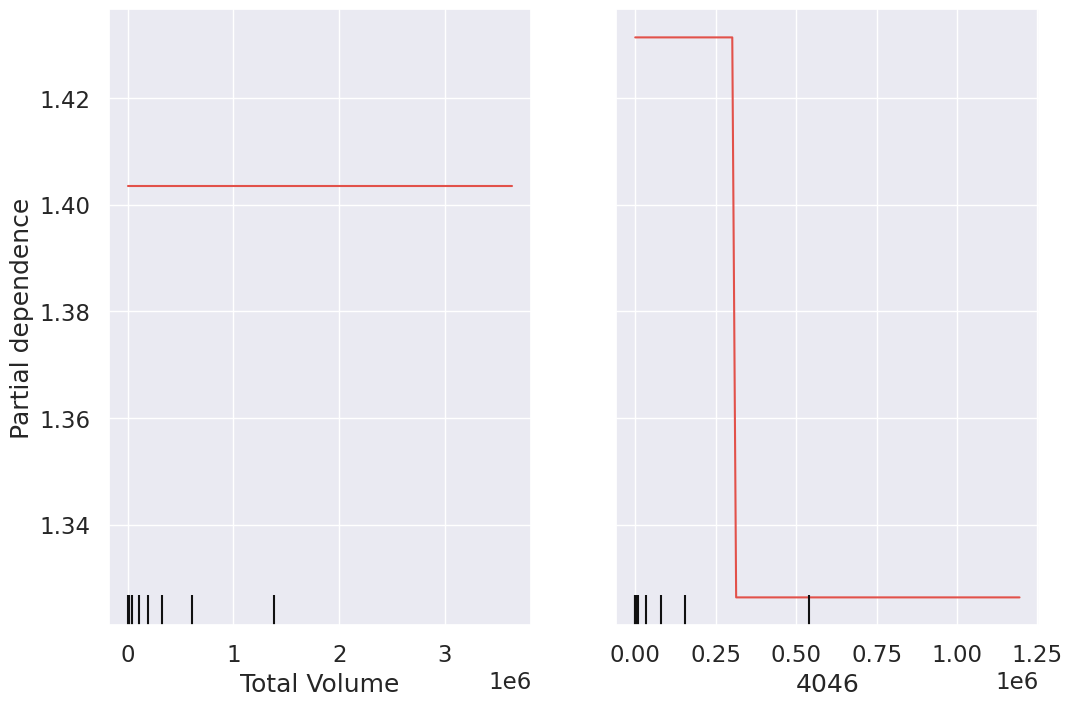

In [75]:
from sklearn.inspection import PartialDependenceDisplay

# Choose features for which you want to create PDPs
# Here, I'm assuming you want to look at the first two features, but you can choose any
features = [0, 1]  # Replace with the actual names or indices of the features you're interested in

# Create the PDPs for the chosen features
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(tree_model, X_train, features, ax=ax)

plt.show()


##**Comparision of Models**

In [76]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Initialize models to compare: Linear Regression, Decision Tree, Random Forest
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42)
}

# Dictionary to hold the performance of each model
model_performance = {}

# Fit and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    model_performance[name] = mse

model_performance


{'Linear Regression': 0.06811867888661227,
 'Decision Tree': 0.03319624657534247,
 'Random Forest': 0.016758771109589034}

In [80]:
data1 = pd.read_csv('https://raw.githubusercontent.com/Jashu284/DSMT/main/avocado.csv')
data1.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [81]:
# Assuming 'data1' is your DataFrame
columns_to_drop = ['Total Volume', 'Total Bags', '4770', 'Unnamed: 0']
df1 = data1.drop(columns=columns_to_drop)


In [94]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()

# Convert the pandas DataFrame to H2OFrame
h2o_df = h2o.H2OFrame(df1)


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,24 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,4 days
H2O_cluster_name:,H2O_from_python_unknownUser_yt8dlx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [95]:
t_rows=0.80
df_train, df_test = h2o_df.split_frame([t_rows])
print(df_train.shape)
print(df_test.shape)

(14562, 10)
(3687, 10)


In [96]:
X=h2o_df.columns
y_numeric ='AveragePrice'
X.remove(y_numeric)
X

['Date',
 '4046',
 '4225',
 'Small Bags',
 'Large Bags',
 'XLarge Bags',
 'type',
 'year',
 'region']

In [97]:
aml = H2OAutoML(max_runtime_secs=240, seed=1)

In [98]:
aml.train(x=X,y=y_numeric,training_frame=df_train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),3/8
# GBM base models (used / total),2/4
# XGBoost base models (used / total),1/2
# DRF base models (used / total),0/1
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [149]:
import h2o
import shap
from h2o.automl import H2OAutoML

# Start the H2O cluster
h2o.init()

# Assume you have already run H2OAutoML and have the AutoML object
# automl = H2OAutoML(max_runtime_secs=3600)
# automl.train(x=features, y=target, training_frame=train_frame)

# Get the best model
best_model = aml.leader

# Convert the test data to H2O frame if it's not already
if not isinstance(X_test, h2o.H2OFrame):
    X_test = h2o.H2OFrame(X_test)

# Predict with the best model (this step is optional, mainly for confirming the model works)
predictions = best_model.predict(X_test)

# Shutdown H2O cluster
h2o.cluster().shutdown()

# Now, create a SHAP explainer - you may need to use the model converted to a format SHAP understands
# This part can be tricky with H2O models because SHAP directly supports models like those from scikit-learn
# For H2O models, you may need to use the H2O's own interpretation tools or convert the model to a supported format

# Initialize SHAP Explainer (hypothetical, as direct support may vary)
# explainer = shap.Explainer(best_model)
# shap_values = explainer(X_test)


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,3 mins 00 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,4 days
H2O_cluster_name:,H2O_from_python_unknownUser_ext99u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


H2OResponseError: Server error water.exceptions.H2OKeyNotFoundArgumentException:
  Error: Object 'StackedEnsemble_AllModels_1_AutoML_2_20240318_31947' not found for argument: key
  Request: GET /3/Models/StackedEnsemble_AllModels_1_AutoML_2_20240318_31947


In [101]:
model_index=0
glm_index=0
glm_model=''
aml_leaderboard_df=aml.leaderboard.as_data_frame()
models_dict={}
for m in aml_leaderboard_df['model_id']:
  models_dict[m]=model_index
  if 'StackedEnsemble' not in m:
    break
  model_index=model_index+1

for m in aml_leaderboard_df['model_id']:
  if 'GLM' in m:
    models_dict[m]=glm_index
    break
  glm_index=glm_index+1
models_dict

{'StackedEnsemble_AllModels_1_AutoML_2_20240318_31947': 0,
 'StackedEnsemble_BestOfFamily_3_AutoML_2_20240318_31947': 1,
 'StackedEnsemble_BestOfFamily_2_AutoML_2_20240318_31947': 2,
 'StackedEnsemble_BestOfFamily_1_AutoML_2_20240318_31947': 3,
 'GBM_1_AutoML_2_20240318_31947': 4,
 'GLM_1_AutoML_2_20240318_31947': 13}

In [102]:
print(model_index)
best_model1 = h2o.get_model(aml.leaderboard[model_index,'model_id'])
best_model1.algo

4


'gbm'

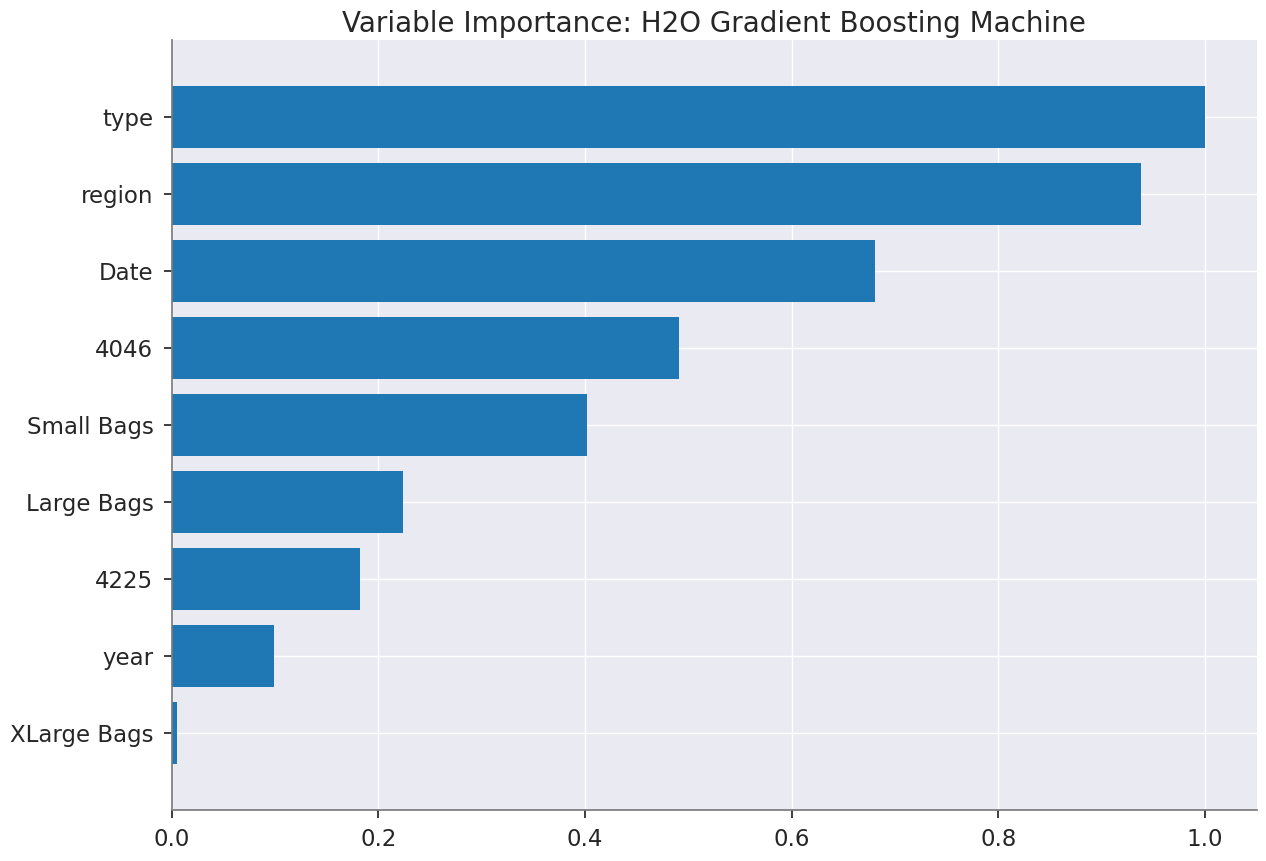

<Figure size 800x550 with 0 Axes>

In [103]:
if best_model1.algo in ['gbm','drf','xrt','xgboost']:
    best_model1.varimp_plot()

In [ ]:
df_p2=df_p.copy()
df_p2['type_encoded1'] = label_encoder.fit_transform(df_p2['type'])
df_p2['region_encoded1'] = label_encoder.fit_transform(df_p2['region'])
X = df_p2.drop(['Total Volume','Total Bags','4770'], axis=1)
y = df_p2['AveragePrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [104]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd

# Assuming 'data' is your DataFrame and 'AveragePrice' is the target variable
data = pd.read_csv('https://raw.githubusercontent.com/Jashu284/DSMT/main/avocado.csv')  # Load your data
X = data.drop('AveragePrice', axis=1)  # Features
y = data['AveragePrice']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the preprocessing for numerical features (if any)
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Define the preprocessing for categorical features (if any)
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Create the modeling pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# The pipeline is now ready to make predictions and evaluate the model


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Unnamed: 0', 'Total Volume', '4046', '4225', '4770', 'Total Bags',
       'Small Bags', 'Large Bags', 'XLarge Bags', 'year'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Date', 'type', 'region'], dtype='object'))])),
                ('regressor', LinearRegression())])

In [78]:
# Assuming X_train has both numerical and categorical columns
# Fill numerical columns with 0 or the mean of the column
for col in numerical_features:
    nan_frame[col] = 0  # or X_train[col].mean()

# Fill categorical columns with a placeholder or the most frequent category
for col in categorical_features:
    nan_frame[col] = 'unknown'  # or X_train[col].mode()[0]

# Now you can safely use this frame for prediction
base_value = round(pipeline.predict(nan_frame)[0], 3)
print(f"Expected value of the output (base value): {base_value}")


Expected value of the output (base value): 279.249


In [105]:
X_test.iloc[0: 1]

,Unnamed: 0,Date,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
8604,6,2018-02-11,218329.7,79239.58,26356.05,2998.74,109735.33,73393.34,34338.97,2003.02,conventional,2018,Columbus


In [106]:
# Make a prediction for the first sample in the X_test set
sample_prediction = round(pipeline.predict(X_test.iloc[0:1])[0], 3)

# Retrieve the actual value using the corresponding index from the y_test set
actual_value = y_test.iloc[0]

# Print the prediction and the actual value
print(f"Current Prediction: {sample_prediction}, Actual value: {actual_value}")


Current Prediction: 0.916, Actual value: 0.82


In [151]:
explain_model = aml.explain(frame = df_test, figsize = (10,8),include_explanations=['pdp'])

H2OResponseError: Server error water.exceptions.H2OKeyNotFoundArgumentException:
  Error: Object 'StackedEnsemble_AllModels_1_AutoML_2_20240318_31947' not found for argument: key
  Request: GET /3/Models/StackedEnsemble_AllModels_1_AutoML_2_20240318_31947


# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

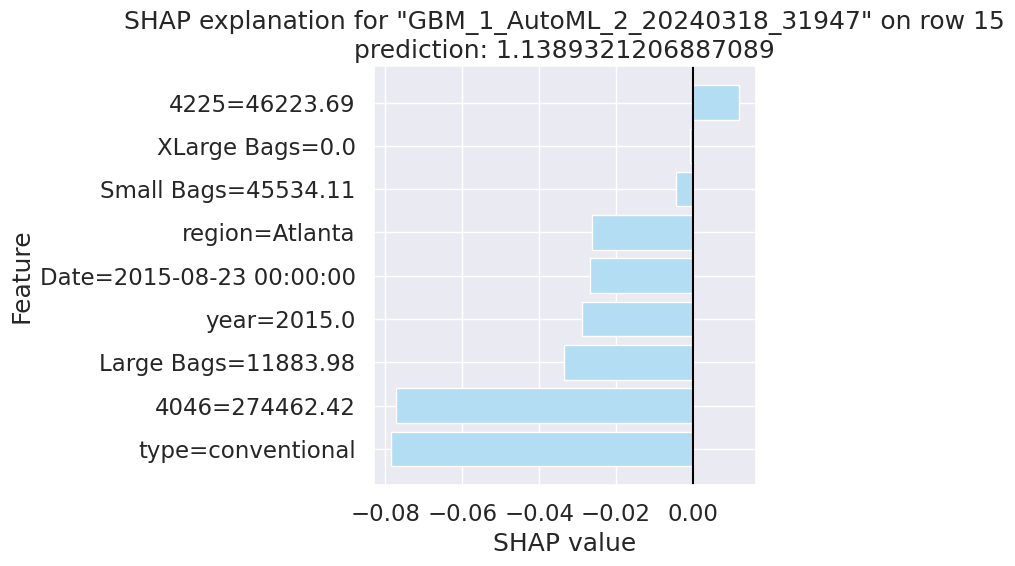

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

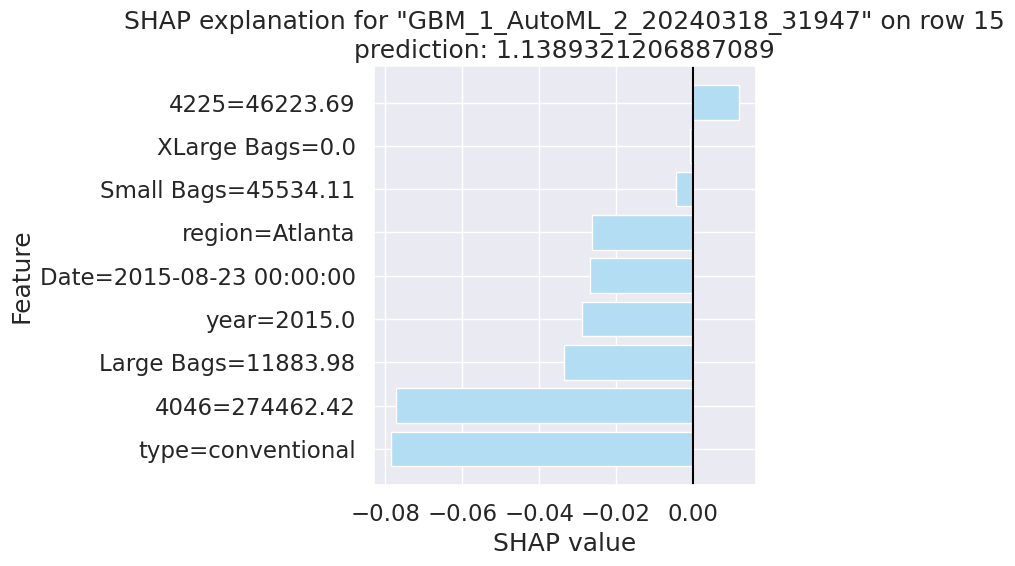

In [107]:
aml.explain_row(frame=df_test, row_index=15, figsize=(8, 6), exclude_explanations=["leaderboard"], top_n_features=10)



Deciphering SHAP dependence plots for linear and tree-based models offers valuable insights into how specific features influence model predictions, whether on a global scale or for individual instances. Here's how to interpret these plots for both types of models:

Linear Model:
Interpreting SHAP dependence plots for linear models tends to be straightforward due to the inherent linearity assumption. Typically, the plot displays a straight line, indicating that as the feature value increases or decreases, its effect on the prediction linearly follows suit.

Slope Direction: The slope direction (positive or negative) reveals whether the feature positively or negatively impacts predictions as its value changes.
Slope Steepness: Steeper slopes denote stronger relationships between the feature and the prediction.
Divergence from Linearity: Despite the linear model assumption, SHAP values may uncover non-linear patterns, hinting at potential inadequacies in capturing complex relationships.
Tree-based Model:
SHAP dependence plots for tree-based models can unveil more intricate patterns due to their ability to capture non-linear relationships and feature interactions.

Curve Shape: Unlike linear models, these plots may exhibit curves, signifying non-linear associations between the feature and the prediction.
Vertical Dispersion: Variability in SHAP values at a specific feature value indicates interactions with other features, implying that the feature's impact on the prediction is influenced by other feature values.
Color Coding: Color-coded points based on another feature's values highlight interaction effects between the features.
General Interpretation Tips:

Feature Importance: Larger deviations from the baseline prediction in dependence plots generally indicate more influential features.
Interactions: While SHAP plots can explicitly depict feature interactions in tree-based models, identifying interactions in linear models may require manual specification.
Predictive Insight: Identifying thresholds where feature impacts significantly change can offer actionable insights for decision-making or further investigation.
In summary, SHAP dependence plots serve as potent tools for comprehending feature-prediction relationships in both linear and tree-based models. Thorough analysis of these plots facilitates a deeper understanding of model behavior and underlying data dynamics

References:- * H20.ai- https://docs.h2o.ai/

OLS Model- http://net-informations.com/ds/mla/ols.html

Linear Regression- https://www.analyticsvidhya.com/blog/2021/05/all-you-need-to-know-about-your-first-machine-learning-model-linear-regression/

Linear Regression Assumptions- https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/assumptions-of-linear-regression/

Github Link- https://github.com/vikram17036/DSMT?tab=MIT-1-ov-file#readme

Dataset- https://www.kaggle.com/datasets/neuromusic/avocado-prices

Github(Reference given by professor) - https://github.com/aiskunks/YouTube/blob/main/A_Crash_Course_in_Statistical_Learning/AutoML/AutoML_Wine_Quality.ipynb

##**MIT License**

Copyright (c) 2024 Jashu284

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.